# 🧠 Análisis Completo de Urolitinas por Metabotipo

## 1. Carga de Datos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset principal
from google.colab import drive
drive.mount('/content/drive')

import re
from pathlib import Path
data_path = Path('/content/drive/MyDrive/ProyectoIntegrador/WAHA_Urolithins_MetabotypesData.dta')
df = pd.read_stata(data_path)
print('Shape:', df.shape)
df.head()

Mounted at /content/drive
Shape: (741, 693)


,patient_id,Metabotype_1,Metabotype_2,Age_,high_sensitivity_CRP,high_sensitivity_CRP2,glucose,glucose2,glycated_hb,glycated_hb2,...,TransFatE_v24,TransFatE_Dif,Cholesterolmg_Dif,Phytosterolstotalmg_Dif,Polyphenolstotalmg_Dif,Alcoholg_Dif,GlycemicIndex_Dif,OtherNuts_v0,OtherNuts_v12,OtherNuts_v24
0,1001.0,1.0,1.0,71.0,0.16,0.09,96.0,89.0,5.8,5.7,...,0.158066,0.127286,-52.48,-46.88,241.47,-1.84,-5.821738,0.0,0.000000,0.0
1,1002.0,1.0,1.0,72.0,0.19,0.20,77.0,77.0,5.8,5.7,...,0.069215,-0.030135,-115.67,-46.31,-20.60,0.00,3.084686,0.0,0.000000,0.0
2,1003.0,1.0,1.0,68.0,0.09,0.10,90.0,78.0,6.2,5.9,...,0.136315,-0.139327,212.34,43.80,295.79,0.00,-16.561873,0.0,0.000000,0.0
3,1004.0,0.0,1.0,74.0,NaN,0.08,94.0,100.0,5.9,5.8,...,0.086978,0.029857,6.45,125.66,336.17,0.90,1.990668,0.0,0.000000,0.0
4,1005.0,2.0,1.0,66.0,0.04,0.11,103.0,125.0,6.1,6.1,...,0.115696,-0.036360,113.90,30.82,685.77,-6.80,9.558450,0.0,13.333333,0.0


## 2. Variables de Urolitinas y Dominios Cognitivos

In [ ]:
uro_vars = [
    'UroA_glu_1_CQ', 'UroB_1_CQ', 'UroB_glu_1_CQ', 'UroC_1_CQ', 'UroC_glu_1_CQ',
    'UroA_2_CQ', 'UroA_glu_2_CQ', 'UroB_2_CQ', 'UroB_glu_2_CQ', 'UroC_2_CQ', 'UroC_glu_2_CQ'
]

domain_cols = [
    'Composite_MemoryMCHANGE', 'Composite_LanguageMCHANGE', 'Composite_PerceptionMCHANGE',
    'Composite_FrontalMCHANGE', 'Composite_EEFFMCHANGE', 'Composite_SPEEDMCHANGE', 'Composite_GlobalMCHANGE'
]


## 3. Segmentación por Metabotipo y Filtrado de Urolitinas

In [ ]:
present_df = pd.DataFrame({
    col + '_present': (df[col] > 0).astype(int)
    for col in uro_vars
})
df = pd.concat([df, present_df], axis=1).copy()

metabotype_datasets = {}
for metabotype, group in df.groupby("Metabotype_1"):
    metabotype = int(metabotype)
    presence_summary = {
        col: (group[col + "_present"].sum() / group.shape[0]) * 100
        for col in uro_vars
    }
    kept_uros = [col for col, pct in presence_summary.items() if pct >= 10]
    cols_to_keep = kept_uros + [col + "_present" for col in kept_uros] + domain_cols
    reduced_df = group[cols_to_keep].dropna()
    metabotype_datasets[metabotype] = reduced_df

{f"Metabotype {k}": v.shape for k, v in metabotype_datasets.items()}


{'Metabotype 0': (217, 19),
 'Metabotype 1': (207, 17),
 'Metabotype 2': (116, 29)}

## 4. Transformación Yeo-Johnson por Metabotipo

In [ ]:
from sklearn.preprocessing import PowerTransformer

def transformar_por_metabotipo(datasets_dict, suffix="_yj"):
    transformed_sets = {}
    for metabotype, df_sub in datasets_dict.items():
        df_sub = df_sub.copy()
        uq_cols = [col for col in df_sub.columns if col.endswith("_CQ")]
        pt = PowerTransformer(method='yeo-johnson')
        transformed_data = pt.fit_transform(df_sub[uq_cols])
        df_transformed = pd.DataFrame(transformed_data, columns=[col + suffix for col in uq_cols], index=df_sub.index)
        df_final = pd.concat([df_sub, df_transformed], axis=1)
        transformed_sets[metabotype] = df_final
    return transformed_sets

transformed_dfs = transformar_por_metabotipo(metabotype_datasets)


## 5. Visualización de Distribuciones Transformadas

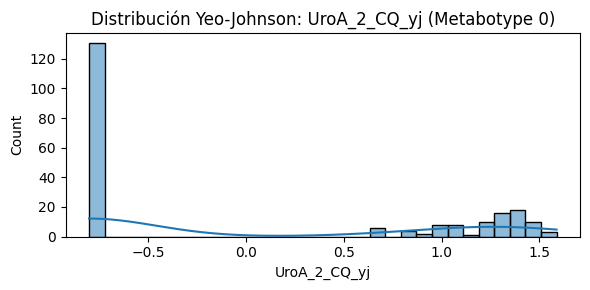

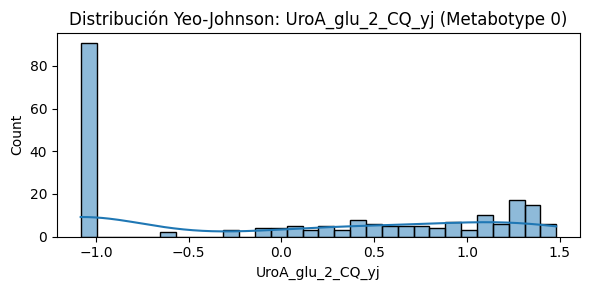

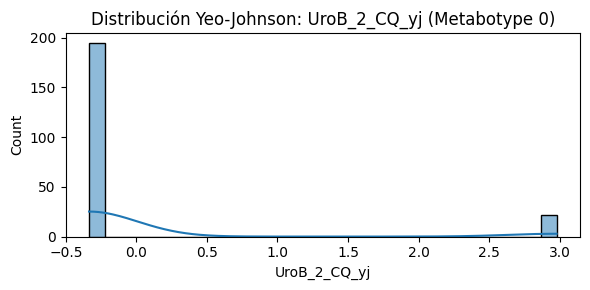

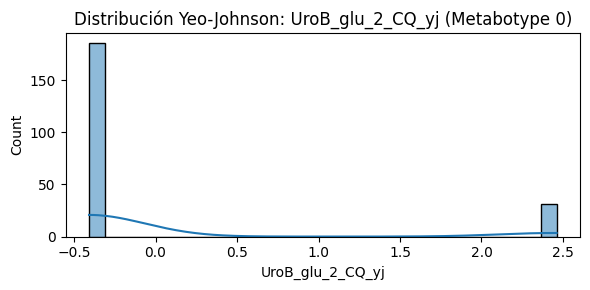

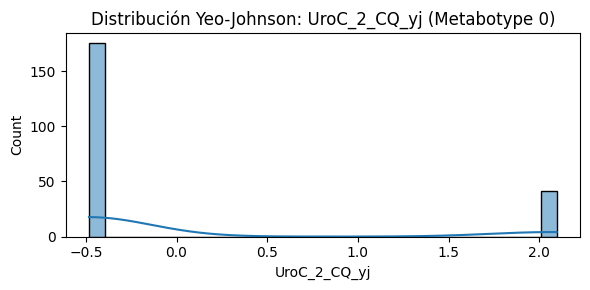

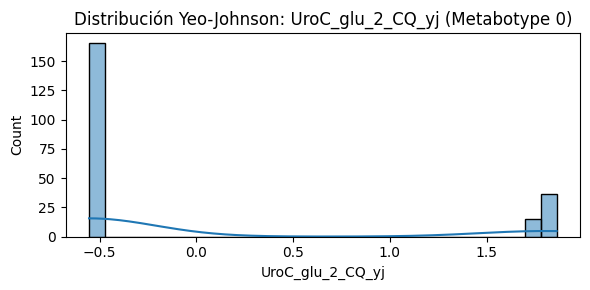

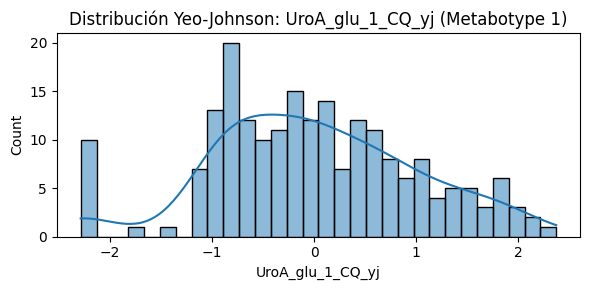

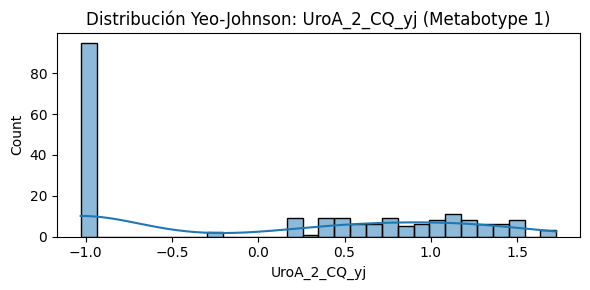

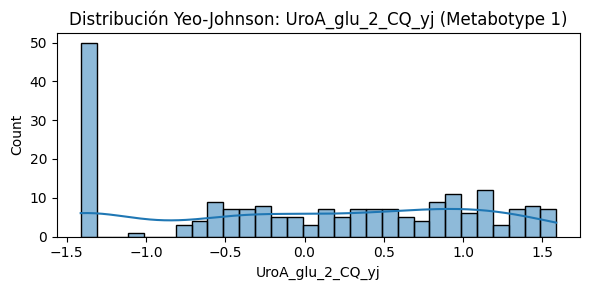

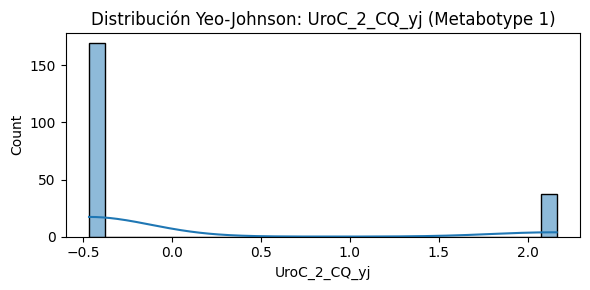

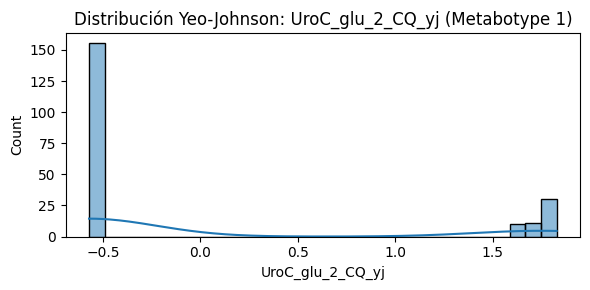

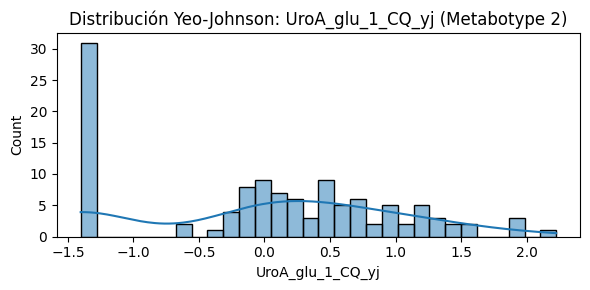

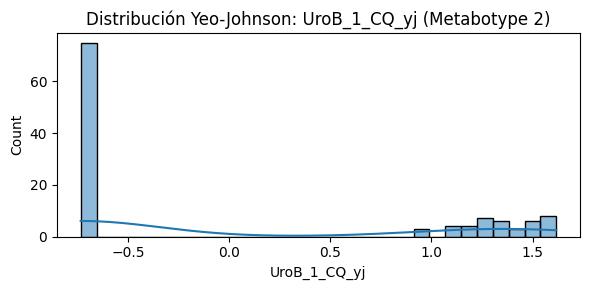

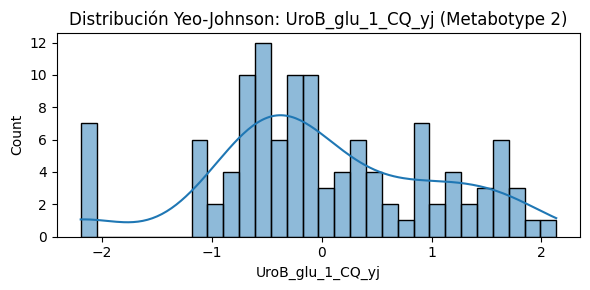

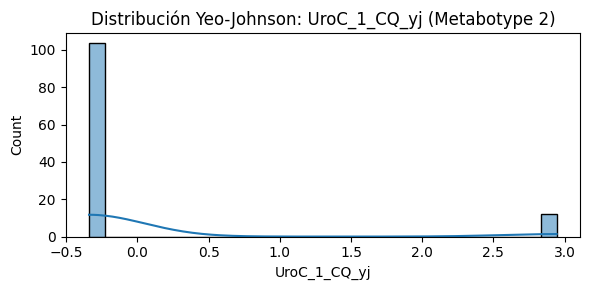

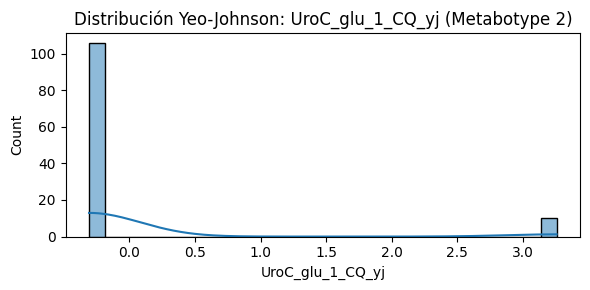

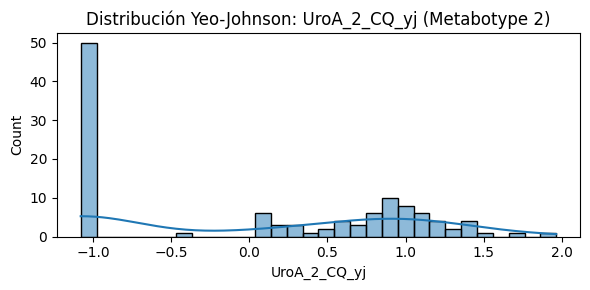

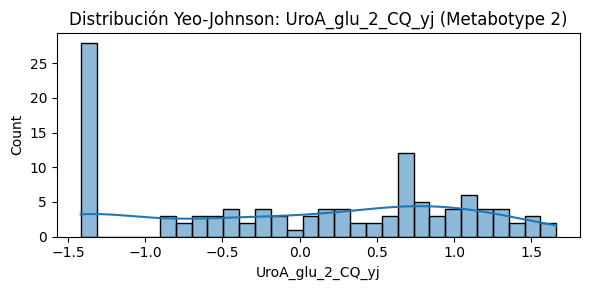

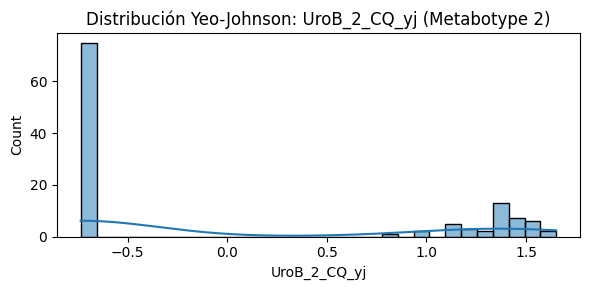

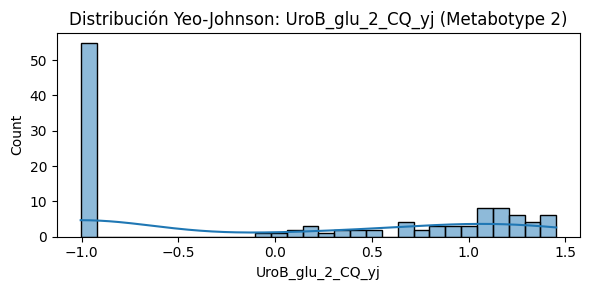

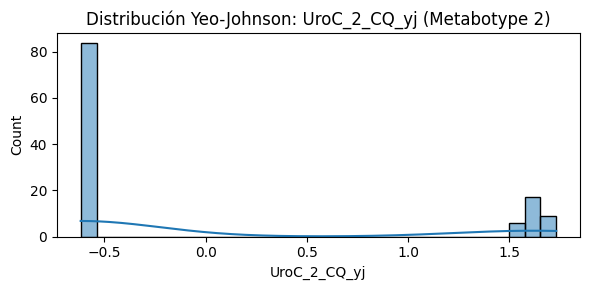

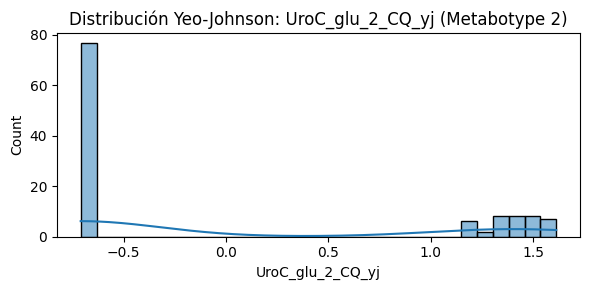

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for metabotype, df_t in transformed_dfs.items():
    yj_cols = [col for col in df_t.columns if col.endswith("_yj")]
    for col in yj_cols:
        plt.figure(figsize=(6, 3))
        sns.histplot(df_t[col], kde=True, bins=30)
        plt.title(f"Distribución Yeo-Johnson: {col} (Metabotype {metabotype})")
        plt.tight_layout()
        plt.show()


## 6. Heatmaps de Correlación

<ipython-input-16-a07acc5d4938>:7: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


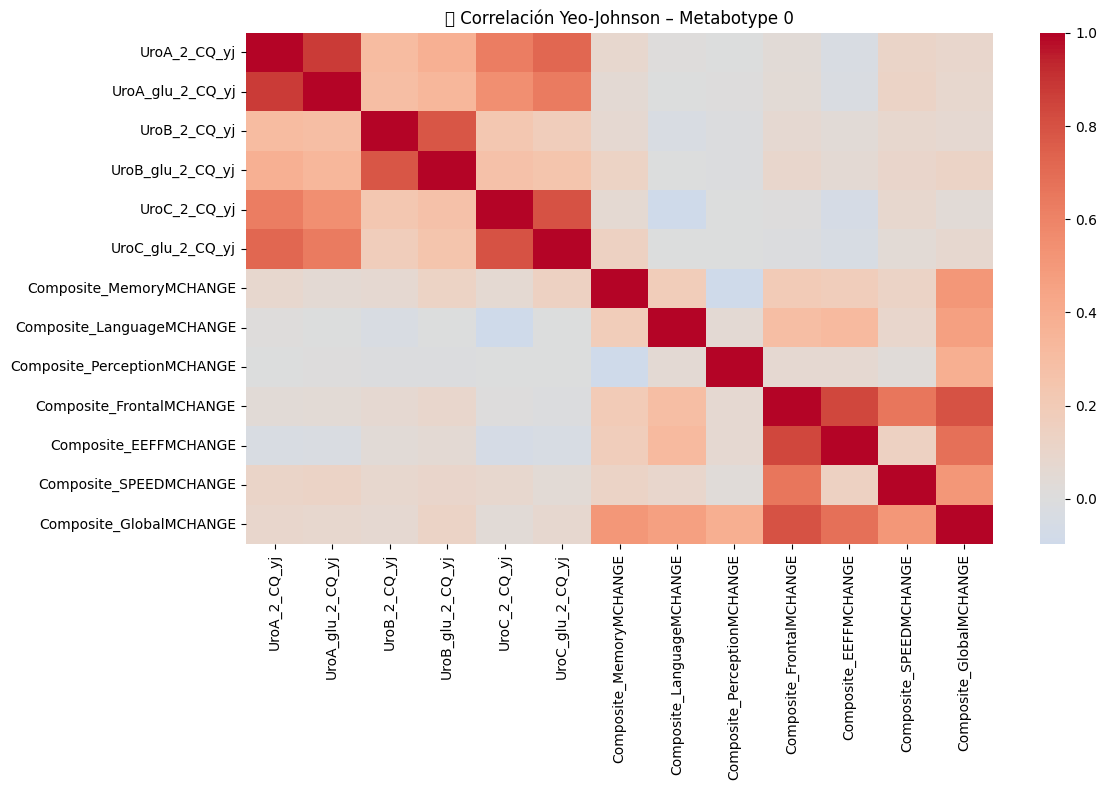

<ipython-input-16-a07acc5d4938>:7: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


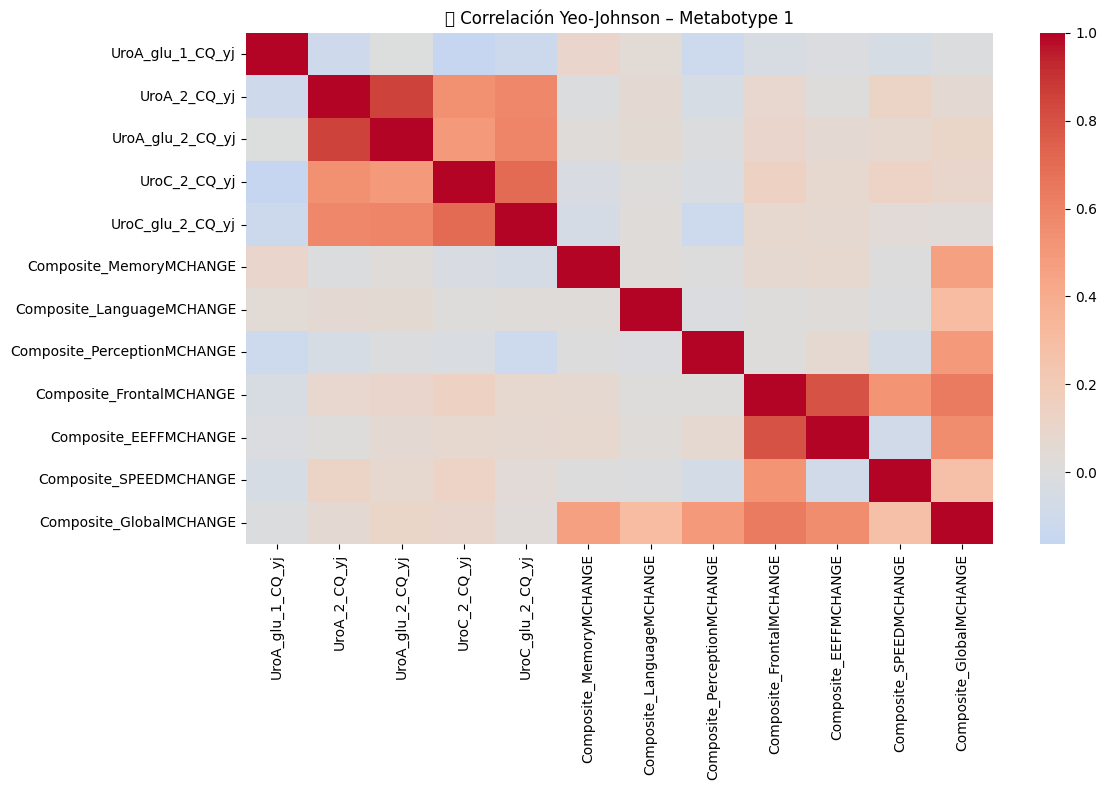

<ipython-input-16-a07acc5d4938>:7: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


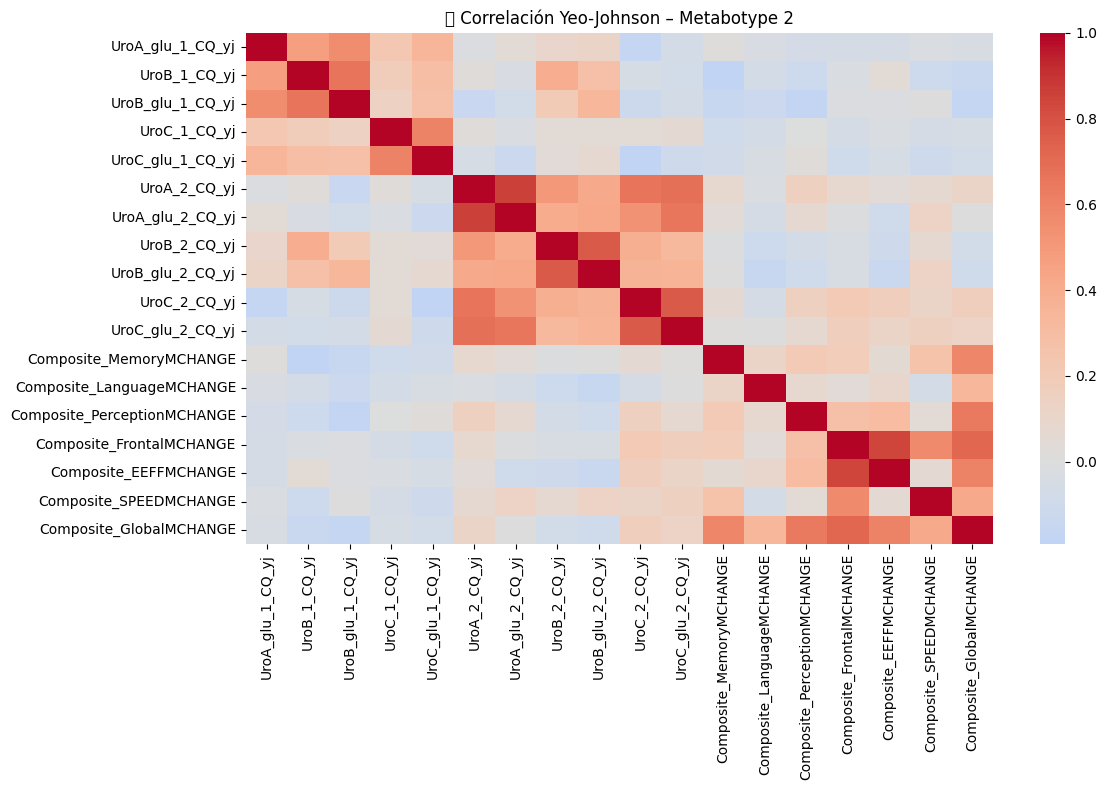

In [ ]:
for metabotype, df_t in transformed_dfs.items():
    yj_cols = [col for col in df_t.columns if col.endswith("_yj")]
    df_corr = df_t[yj_cols + domain_cols].dropna()
    plt.figure(figsize=(12, 8))
    sns.heatmap(df_corr.corr(), annot=False, cmap="coolwarm", center=0)
    plt.title(f"🔍 Correlación Yeo-Johnson – Metabotype {metabotype}")
    plt.tight_layout()
    plt.show()


## 7. Random Forest por Metabotipo

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer

r2_results = {}

for metabotype, df_t in transformed_dfs.items():
    yj_cols = [col for col in df_t.columns if col.endswith("_yj")]

    df_model = df_t[yj_cols + domain_cols].copy()

    imputer = SimpleImputer(strategy="median")
    df_model[df_model.columns] = imputer.fit_transform(df_model)

    X = df_model[yj_cols]
    y = df_model[domain_cols]

    if len(X) < 20:
        print(f" Metabotype {metabotype} - Muy pocos datos ({len(X)})")
        continue

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2_metabotype = {col: r2_score(y_test[col], y_pred[:, i]) for i, col in enumerate(y.columns)}
    r2_results[metabotype] = r2_metabotype

    print(f" R² por dominio - Metabotype {metabotype}")
    for k, v in r2_metabotype.items():
        print(f"{k}: {v:.3f}")


📈 R² por dominio - Metabotype 0
Composite_MemoryMCHANGE: 0.085
Composite_LanguageMCHANGE: -0.124
Composite_PerceptionMCHANGE: -0.286
Composite_FrontalMCHANGE: -0.049
Composite_EEFFMCHANGE: -0.119
Composite_SPEEDMCHANGE: -0.165
Composite_GlobalMCHANGE: -0.122

📈 R² por dominio - Metabotype 1
Composite_MemoryMCHANGE: -0.651
Composite_LanguageMCHANGE: -0.727
Composite_PerceptionMCHANGE: -0.472
Composite_FrontalMCHANGE: 0.016
Composite_EEFFMCHANGE: -0.039
Composite_SPEEDMCHANGE: 0.008
Composite_GlobalMCHANGE: -0.126

📈 R² por dominio - Metabotype 2
Composite_MemoryMCHANGE: -0.396
Composite_LanguageMCHANGE: -0.296
Composite_PerceptionMCHANGE: -0.208
Composite_FrontalMCHANGE: -0.400
Composite_EEFFMCHANGE: -0.523
Composite_SPEEDMCHANGE: -0.102
Composite_GlobalMCHANGE: -0.744


En este avance, nos propusimos explorar la relación entre los perfiles de urolitinas y el desempeño cognitivo en función del metabotipo. Para lograrlo, realizamos una serie de transformaciones que nos permitieron preparar adecuadamente los datos antes de aplicar un modelo de aprendizaje automático.

Primero, aplicamos la transformación Yeo-Johnson a las variables relacionadas con las urolitinas para corregir la asimetría y mejorar la distribución. Luego, segmentamos el análisis por metabotipo, lo que nos permitió observar patrones diferenciados según el grupo al que pertenecía cada participante.

También identificamos que algunos registros contenían valores faltantes, por lo que decidimos imputar los datos utilizando la mediana. Esta decisión nos permitió conservar la mayor cantidad de observaciones posibles y evitar perder información relevante.

Posteriormente, entrenamos un modelo de Random Forest multisalida, que nos permitió predecir múltiples dominios cognitivos en paralelo. Evaluamos su desempeño mediante la métrica R², y aunque obtuvimos resultados aceptables en algunos casos, también observamos que el modelo tiene margen de mejora, sobre todo en ciertos metabotipos y dominios específicos.

Por ello, como siguiente paso, consideramos importante reevaluar la estructura y calidad de los datos junto con la universidad de Barcelona, con el objetivo de enriquecer el conjunto de datos, reducir el ruido, y explorar nuevas variables que puedan aportar al modelo. Estamos convencidos de que este proceso nos permitirá mejorar el desempeño predictivo y obtener conclusiones más sólidas y aplicables.